### The BeachNourisher Module

In this notebook we test and show the functionality of the BeachNourisher module within `CASCADE`.

In [1]:
import numpy as np
import sys
import time
from pathlib import Path

sys.path.extend(['/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D', '/Users/KatherineAnardeWheels/PycharmProjects/brie', '/Users/KatherineAnardeWheels/PycharmProjects/CASCADE'])
# datadir = "./B3D_Inputs/"  # laptop 
# Path(datadir)
datadir = "/Users/KatherineAnardeWheels/PycharmProjects/CASCADE/B3D_Inputs/"  # laptop

from CASCADE import Cascade
from scripts import CASCADE_plotters as CASCADE_Plt

Here we initialize `CASCADE` with the default wave climate and dune dynamics (average dune growth rate of 0.45), but increase the rate of sea level rise to 0.007 m/yr and simulate only one 500 m `Barrier3D` domain. All other optional modules are turned off (alongshore sediment transport from `BRIE`, community dynamics from `CHOME`, and roadway management). 

The nourishment module requires three input variables at initialization:
- `artificial_max_dune_ele`  # dune rebuilt to this height every nourishment, unless otherwise specified
- `nourishment_interval`  # yrs
- `nourishment_volume` 

CONTINUE EXPLAINING MODEL COMPONENTS SEQUENTIALLY HERE...turn dune migration off once we nourish (we don't allow the dune line to move seaward, as with natural progradation)

In [2]:
# start a model by nourishing one B3D domain at discrete intervals, here we chose every 15 years; 
# no roadway mgmt, otherwise default conditions except increase sea level rise to 0.005 m/yr
nt = 50
cascade = Cascade(
    datadir,
    name="nourishment_intervals",
    sea_level_rise_rate=0.007,
    alongshore_section_count=1,
    time_step_count=nt,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
#     community_dynamics_module=False,
    artificial_max_dune_ele=3.7,  # dune rebuilt to this height every nourishment
    nourishment_interval=15,  # yrs
    nourishment_volume=100,  # m^3/m -- 100 should produce about 20 m of shoreline progradation
)


# --------- LOOP ---------
Time = time.time()

for time_step in range(nt - 1):
    # Print time step to screen (NOTE: time_index in each model is time_step+1)
    print("\r", "Time Step: ", time_step, end="")
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break

 Time Step:  48

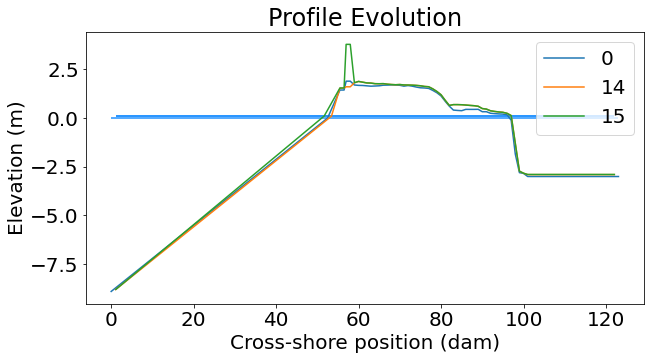

In [7]:
# time_step = np.arange(0,21,10)
time_step = [0,14,15]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
# fig.set_xlim([50,60])
# fig.set_ylim([-1,3])

subplots of beach width, nourishment volume

In [4]:

cascade.nourishments[0].beach_width


NameError: name 'iB3D' is not defined